In [5]:
import os
from google.colab import files
import zipfile

# 1. Upload the zip file
print("--- Please select HC18_Dataset.zip or training_set.zip and test_set.zip from your computer ---")
uploaded = files.upload()

# 2. Unzip all uploaded files
for zip_filename in uploaded.keys():
    print(f"Unzipping {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall("/content/")

print("✅ Unzip complete! Checking folder structure:")
print(os.listdir("/content/"))

--- Please select HC18_Dataset.zip or training_set.zip and test_set.zip from your computer ---


Saving test_set.zip to test_set.zip
Saving training_set.zip to training_set.zip
Unzipping test_set.zip...
Unzipping training_set.zip...
✅ Unzip complete! Checking folder structure:
['.config', 'training_set.zip', 'test_set.zip', 'test_set', 'training_set', 'sample_data']


In [6]:
from google.colab import files
print("Please upload file csv")
uploaded = files.upload()


Please upload file csv


Saving test_set_pixel_size.csv to test_set_pixel_size.csv
Saving training_set_pixel_size_and_HC.csv to training_set_pixel_size_and_HC.csv


Contents of /content/:
['.config', 'training_set.zip', 'test_set.zip', 'test_set', 'test_set_pixel_size.csv', 'training_set', 'training_set_pixel_size_and_HC.csv', 'sample_data']

Contents of /content/training_set/:
['355_HC_Annotation.png', '592_2HC_Annotation.png', '280_HC.png', '135_HC_Annotation.png', '011_HC.png', '078_HC_Annotation.png', '705_HC.png', '399_2HC.png', '730_2HC_Annotation.png', '327_2HC_Annotation.png', '720_2HC_Annotation.png', '785_2HC_Annotation.png', '448_HC.png', '508_HC.png', '525_HC.png', '585_HC.png', '619_HC.png', '029_HC_Annotation.png', '688_HC_Annotation.png', '796_HC_Annotation.png', '780_HC_Annotation.png', '382_2HC.png', '534_HC.png', '566_2HC.png', '234_HC_Annotation.png', '029_HC.png', '750_HC.png', '799_HC_Annotation.png', '198_HC.png', '240_HC.png', '734_HC_Annotation.png', '441_HC.png', '329_HC.png', '299_2HC_Annotation.png', '149_HC.png', '715_HC.png', '747_HC.png', '677_HC_Annotation.png', '032_2HC_Annotation.png', '773_2HC.png', '631_HC_Annota

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]



--- Starting Training Loop --
Epoch 1 | Train MAE: 166.13 mm | Val MAE: 152.90 mm
Epoch 2 | Train MAE: 134.92 mm | Val MAE: 116.17 mm
Epoch 3 | Train MAE: 82.74 mm | Val MAE: 71.69 mm
Epoch 4 | Train MAE: 33.60 mm | Val MAE: 17.09 mm
Epoch 5 | Train MAE: 21.27 mm | Val MAE: 22.94 mm
Epoch 6 | Train MAE: 16.61 mm | Val MAE: 14.36 mm
Epoch 7 | Train MAE: 15.16 mm | Val MAE: 15.63 mm
Epoch 8 | Train MAE: 13.08 mm | Val MAE: 13.01 mm
Epoch 9 | Train MAE: 15.19 mm | Val MAE: 14.48 mm
Epoch 10 | Train MAE: 13.88 mm | Val MAE: 15.42 mm
Epoch 11 | Train MAE: 13.32 mm | Val MAE: 14.34 mm
Epoch 12 | Train MAE: 10.32 mm | Val MAE: 13.89 mm
Epoch 13 | Train MAE: 9.31 mm | Val MAE: 12.90 mm
Epoch 14 | Train MAE: 9.14 mm | Val MAE: 12.69 mm
Epoch 15 | Train MAE: 8.50 mm | Val MAE: 12.45 mm


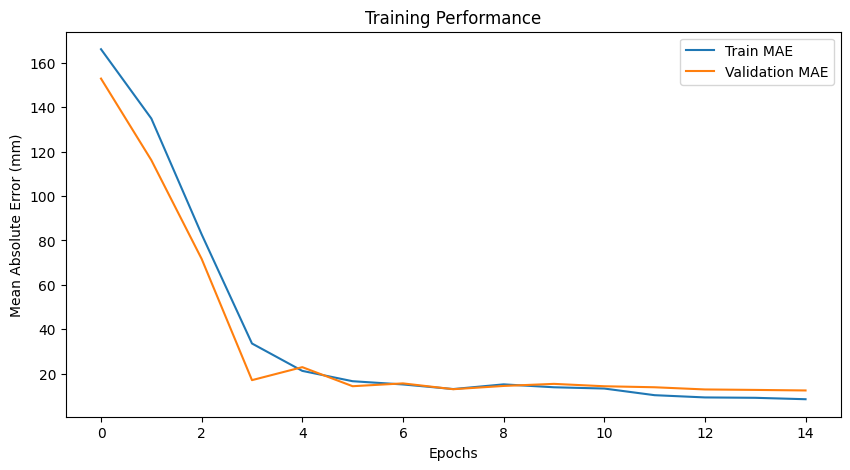

Model saved as 'hc18_model_colab.pth'


In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

print("Contents of /content/:")
print(os.listdir("/content/"))

print("\nContents of /content/training_set/:")

if os.path.exists("/content/training_set"):
    print(os.listdir("/content/training_set"))
else:
    print("Directory /content/training_set/ does not exist.")

# 1. CONFIGURATION
if os.path.exists("/content/training_set"):
    ROOT_DIR = "/content"
    print("Dataset 'training_set' found directly in /content.")
elif os.path.exists("/content/HC18_Dataset/training_set"):
    ROOT_DIR = "/content/HC18_Dataset"
    print("Dataset 'training_set' found in /content/HC18_Dataset.")
else:
    ROOT_DIR = "/content"
    print("⚠️ WARNING: Dataset folder 'training_set' or 'HC18_Dataset/training_set' not found.")
    print("Please ensure the dataset has been uploaded and unzipped correctly (e.g., by running the first code cell). Dataset loading will likely fail.")

# Define DATA_DIR and CSV_FILE based on the determined ROOT_DIR
DATA_DIR = os.path.join(ROOT_DIR, "training_set")
CSV_FILE = os.path.join(DATA_DIR, "training_set_pixel_size_and_HC.csv")

print(f"\nChecking for CSV file in {DATA_DIR}:")
if os.path.exists(DATA_DIR):
    print(os.listdir(DATA_DIR))
else:
    print(f"Directory {DATA_DIR} does not exist.")
# --------

BATCH_SIZE = 16
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Training on device: {DEVICE}")

# 2. DATASET CLASS
class HC18Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.df.columns.values[0] = "filename"
        self.df.columns.values[2] = "hc_mm"

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            return None

        label = float(self.df.iloc[idx, 2]) # Head Circumference (mm)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define Transforms (Resize to 224x224 for ResNet)
transforms_def = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load and Split Data
try:
    # --- Robust CSV file path resolution --- START
    current_csv_file_path = CSV_FILE
    if not os.path.exists(current_csv_file_path):
        print(f"DEBUG: Expected CSV file '{os.path.basename(current_csv_file_path)}' not found in '{DATA_DIR}'.")
        print("Attempting to locate CSV file from /content/ and move/copy it to DATA_DIR.")

        found_csv_in_root = None
        base_csv_name = "training_set_pixel_size_and_HC"

        possible_csv_files_in_root = [f for f in os.listdir("/content/") if f.startswith(base_csv_name) and f.endswith(".csv")]
        possible_csv_files_in_root.sort(reverse=True)

        if possible_csv_files_in_root:
            for fname in possible_csv_files_in_root:
                if fname == base_csv_name + ".csv":
                    found_csv_in_root = os.path.join("/content/", fname)
                    break
            if not found_csv_in_root: # If exact name not found, take the first from sorted list (most recent renamed)
                 found_csv_in_root = os.path.join("/content/", possible_csv_files_in_root[0])

        if found_csv_in_root and os.path.exists(found_csv_in_root):
            print(f"DEBUG: Found CSV file '{os.path.basename(found_csv_in_root)}' in /content/.")
            # Ensure DATA_DIR exists before copying
            os.makedirs(DATA_DIR, exist_ok=True)
            import shutil
            shutil.copy(found_csv_in_root, current_csv_file_path) # Copy to expected name in DATA_DIR
            print(f"DEBUG: Copied '{os.path.basename(found_csv_in_root)}' to '{current_csv_file_path}'.")
            CSV_FILE = current_csv_file_path # Update CSV_FILE to point to the correct path
        else:
            print("DEBUG: No suitable CSV file found in /content/ to copy.")
    # --- Robust CSV file path resolution --- END

    full_dataset = HC18Dataset(CSV_FILE, DATA_DIR, transform=transforms_def)

    # Split 80% Train, 20% Validation
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"✅ Data Loaded: {train_size} training images, {val_size} validation images.")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# 3. BUILD MODEL & TRAIN
model = models.resnet18(pretrained=True)

# Modify the final layer for Regression (Output = 1 value)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 1)
)
model = model.to(DEVICE)

criterion = nn.L1Loss() # MAE Metric (Mean Absolute Error)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("\n--- Starting Training Loop --")
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        if images is None: continue
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            if images is None: continue
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).squeeze()
            val_loss += criterion(outputs, labels).item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train MAE: {avg_train_loss:.2f} mm | Val MAE: {avg_val_loss:.2f} mm")

# 4. PLOT RESULTS
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MAE')
plt.plot(val_losses, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (mm)')
plt.title('Training Performance')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'hc18_model_colab.pth')
print("Model saved as 'hc18_model_colab.pth'")

In [8]:
# 5. TEST ON A SINGLE IMAGE
data_iter = iter(val_loader)
images, labels = next(data_iter)

model.eval()
with torch.no_grad():
    preds = model(images.to(DEVICE)).squeeze()

print("\n--- Sample Predictions ---")
for i in range(3):
    print(f"True HC: {labels[i].item():.2f} mm | Predicted HC: {preds[i].item():.2f} mm | Error: {abs(labels[i].item() - preds[i].item()):.2f} mm")


--- Sample Predictions ---
True HC: 71.90 mm | Predicted HC: 75.95 mm | Error: 4.05 mm
True HC: 72.51 mm | Predicted HC: 73.06 mm | Error: 0.55 mm
True HC: 79.80 mm | Predicted HC: 82.27 mm | Error: 2.47 mm


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images).squeeze()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# 1. Get Data
print("Generating data...")
y_pred, y_true = get_all_predictions(model, val_loader, DEVICE)

# 2. Calculate Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("-" * 30)
print("📊 METRICS")
print("-" * 30)
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")
print(f"Root Mean Squared Error:   {rmse:.2f} mm")
print(f"R-Squared Score (R²):      {r2:.4f}")
print("-" * 30)

Generating data...
------------------------------
📊 METRICS
------------------------------
Mean Absolute Error (MAE): 12.40 mm
Root Mean Squared Error:   17.16 mm
R-Squared Score (R²):      0.9130
------------------------------


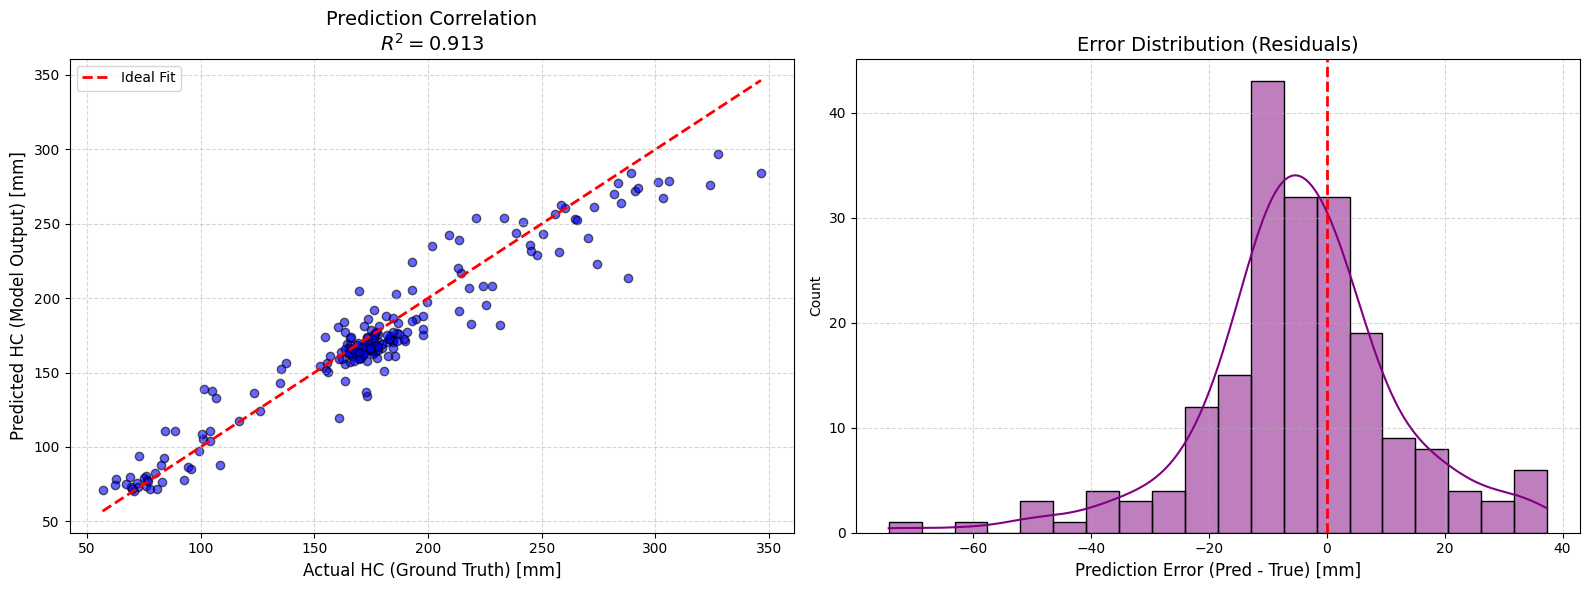

In [10]:
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np

def plot_regression_analysis(y_true, y_pred, r2):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Actual vs Predicted ---
    axes[0].scatter(y_true, y_pred, alpha=0.6, color='blue', edgecolors='k')

    # Draw the ideal x=y line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Fit')

    axes[0].set_xlabel('Actual HC (Ground Truth) [mm]', fontsize=12)
    axes[0].set_ylabel('Predicted HC (Model Output) [mm]', fontsize=12)
    axes[0].set_title(f'Prediction Correlation\n$R^2 = {r2:.3f}$', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # --- Plot 2: Residuals (Error Distribution) ---
    errors = y_pred - y_true
    sns.histplot(errors, kde=True, ax=axes[1], color='purple', bins=20)

    axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Prediction Error (Pred - True) [mm]', fontsize=12)
    axes[1].set_title('Error Distribution (Residuals)', fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- Collect all predictions and true labels from the validation set ---
y_true_list = []
y_pred_list = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        if images is None: continue # Skip if an image was not loaded
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images).squeeze()
        y_true_list.append(labels.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

# Calculate R-squared score
r2 = r2_score(y_true, y_pred)

plot_regression_analysis(y_true, y_pred, r2)


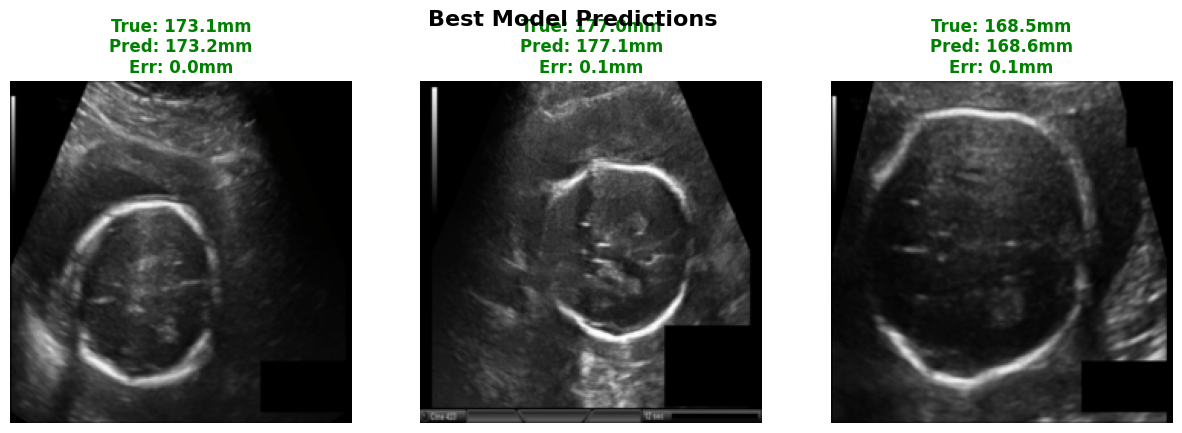

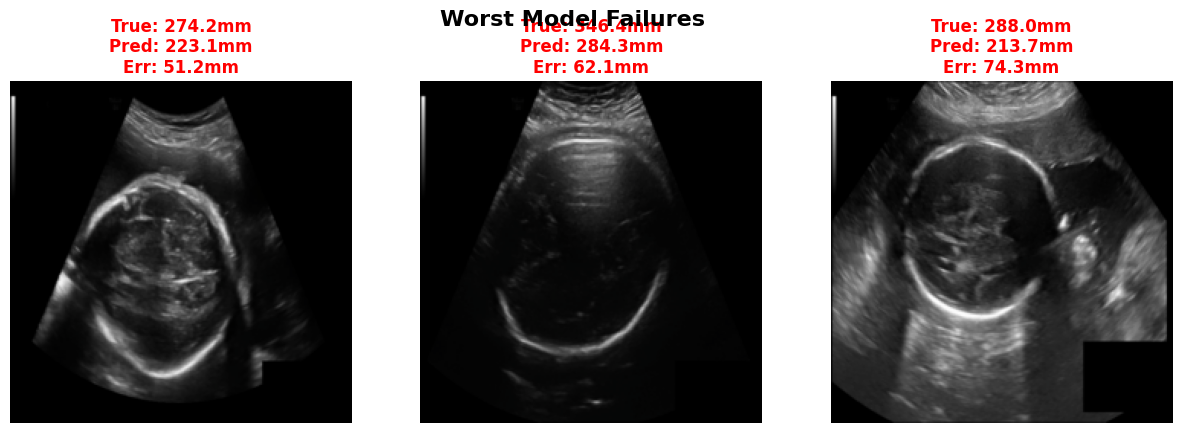

In [11]:
def visualize_best_worst(model, loader, device, n=3):
    model.eval()
    results = []

    # Collect all individual sample data
    with torch.no_grad():
        for i, (image, label) in enumerate(loader.dataset):
            # Un-normalize image for display (approximate inverse of ImageNet stats)
            # This makes the ultrasound look gray again instead of weirdly colored
            disp_img = image.permute(1, 2, 0).numpy()
            disp_img = disp_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            disp_img = np.clip(disp_img, 0, 1)

            # Predict
            input_tensor = image.unsqueeze(0).to(device)
            pred = model(input_tensor).item()
            true = label.item()
            error = abs(pred - true)

            results.append((disp_img, true, pred, error))

    # Sort by Error
    results.sort(key=lambda x: x[3]) # Sort by error (ascending)

    best_samples = results[:n]       # Smallest errors
    worst_samples = results[-n:]     # Largest errors

    # Plotting Function
    def plot_samples(samples, title):
        fig, axes = plt.subplots(1, n, figsize=(15, 5))
        fig.suptitle(title, fontsize=16, weight='bold')

        for i, (img, true, pred, err) in enumerate(samples):
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"True: {true:.1f}mm\nPred: {pred:.1f}mm\nErr: {err:.1f}mm",
                              color=('green' if err < 5 else 'red'), fontweight='bold')

    plot_samples(best_samples, "Best Model Predictions")
    plt.show()

    plot_samples(worst_samples, "Worst Model Failures")
    plt.show()

# Run the visualization (Takes a moment to process the validation set)
visualize_best_worst(model, val_loader, DEVICE, n=3)